# Recommender system A/B-test <a class="tocSkip">

The task is to evaluate the correctness of the test (intersections the audience with a competing test, the coincidence of the test and marketing events, other problems of the test time boundaries) and analyze the test results.

Test description:
- Test name: `recommender_system_test`;
- groups: A - control, B - new payment funnel;
- launch date: 2020-12-07;
- date of stopping the recruitment of new users: 2020-12-21;
- stop date: 2021-01-04;
- audience: 15% of new users from the EU region;
- purpose of the test: testing changes associated with the introduction of an improved recommender system;
- expected number of test participants: 6000;
- expected effect: in 14 days from the moment of registration users will show an improvement in each metric by at least 10%:
    - conversions to view product cards — `product_page` event,
    - cart views — `product_cart`,
    - purchases - `purchase`.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
import warnings

In [29]:
pd.options.display.float_format = '{: .2f}'.format
plt.rcParams.update({'font.size': 13})
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Data preprocessing<a id="part1"></a>

In [2]:
def show_info(df):
    '''
    Функция выводит две первые строки датафрейма и информацию.
    '''
    df.info()
    display(df.head(2))
def check_duplicates(df):
    '''
    Функция выводит строку "Количество дубликатов:" и указывает количество дубликатов в датафрейме.
    '''
    print('Количество дубликатов в датафрейме:', df.duplicated().sum())
def make_datetime(df, columns):
    '''
    Функция принимает на вход датафрейм и список названий полей и меняет тип данных в указанных полях на datetime, 
    выводит информацию о типах данных в полях.
    '''
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    display(df.dtypes)

## Marketing events data

In [4]:
marketing_events = pd.read_csv('datasets/ab_project_marketing_events.csv')
marketing_events.info()
marketing_events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


name        regions    start_dt   finish_dt
6            Chinese New Year Promo           APAC  2020-01-25  2020-02-07
9   Victory Day CIS (May 9th) Event            CIS  2020-05-09  2020-05-11
4                 4th of July Promo      N.America  2020-07-04  2020-07-11
8   International Women's Day Promo  EU, CIS, APAC  2020-03-08  2020-03-10
11    Dragon Boat Festival Giveaway           APAC  2020-06-25  2020-07-01

In [5]:
print('Number of duplicates:', marketing_events.duplicated().sum())

Number of duplicates: 0


In [6]:
for col in ['start_dt', 'finish_dt']:
    marketing_events[col] = pd.to_datetime(marketing_events[col])
marketing_events.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

## New users data

In [7]:
ab_new_users = pd.read_csv('datasets/final_ab_new_users.csv')
ab_new_users.info()
ab_new_users.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


user_id  first_date     region   device
51952  F61C71718BD6B4D7  2020-12-19         EU  Android
49633  CCBF26C024C43D08  2020-12-19         EU   iPhone
16696  25F1904F4C1302CB  2020-12-21         EU   iPhone
33468  7741F2CD17603321  2020-12-10         EU  Android
55499  3A6DB4DB8BCFD153  2020-12-13  N.America  Android

In [8]:
print('Number of duplicates:', ab_new_users.duplicated().sum())

Number of duplicates: 0


In [9]:
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])
ab_new_users.dtypes

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

Let's make sure that the user registration dates in the dataframe match the data description.

In [10]:
print('Date of the earliest registration', ab_new_users['first_date'].min())
print('Date of the latest registration', ab_new_users['first_date'].max())

Date of the earliest registration 2020-12-07 00:00:00
Date of the latest registration 2020-12-23 00:00:00


In the description of the A/B test and in the description of the data set, it is said that only users who registered before 2020-12-21 are taken into account. Let's delete all records for which a later registration is indicated.

In [11]:
ab_new_users = ab_new_users[ab_new_users['first_date'] < pd.to_datetime('2020-12-22')].copy()
ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56470 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     56470 non-null  object        
 1   first_date  56470 non-null  datetime64[ns]
 2   region      56470 non-null  object        
 3   device      56470 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB


## A/B test events data

In [12]:
ab_events = pd.read_csv('datasets/final_ab_events.csv')
ab_events.info()
ab_events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


user_id             event_dt    event_name  details
389630  80826BD514B93BEB  2020-12-22 20:37:22         login      NaN
124447  4CA75D7125687B0D  2020-12-29 15:26:27  product_cart      NaN
95601   F0B0289A78BFBC63  2020-12-19 21:37:30  product_cart      NaN
193983  335C2A21AC9C7CEC  2020-12-19 11:25:29  product_page      NaN
175986  72B9520D72EB6B7A  2020-12-17 03:00:27  product_page      NaN

There are missing values in the `details` column. This is due to the fact that additional information is not available for all the events. For example, for purchases, `purchase,` this field stores the cost of the purchase in dollars.

In [13]:
print('Number of duplicates:', ab_events.duplicated().sum())

Number of duplicates: 0


In [14]:
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])
ab_events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

Let's make sure that the dates of the events specified in the dataframe match the description of the data.

In [15]:
print('Time of the earliest event', ab_events['event_dt'].min())
print('Time of the latest event', ab_events['event_dt'].max())

Time of the earliest event 2020-12-07 00:00:33
Time of the latest event 2020-12-30 23:36:33


## A/B test participants data

In [16]:
ab_participants = pd.read_csv('datasets/final_ab_participants.csv')
ab_participants.info()
ab_participants.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


user_id group            ab_test
13124  CE55BB3F0FC311B5     B  interface_eu_test
18239  475D57241FE134A5     B  interface_eu_test
18151  8E5BE90F914A61D5     B  interface_eu_test
12935  C0567C30E4764666     B  interface_eu_test
13340  370EB71B5F1AFACE     B  interface_eu_test

In [17]:
print('Number of duplicates:', ab_participants.duplicated().sum())

Number of duplicates: 0


Let's check that among the participants of the `recommender_system_test` test there are no users who registered outside of the analyzed period.

In [18]:
print('Number of recommender system A/B test participants who registered outside of the analyzed period:', 
    len(ab_participants[ab_participants['ab_test'] == 'recommender_system_test']) - ab_participants[ab_participants['ab_test'] == 'recommender_system_test']['user_id'].isin(ab_new_users['user_id']).sum())

Number of recommender system A/B test participants who registered outside of the analyzed period: 0


# Exploratory data analysis and assessment of the test correctness

In [19]:
display(marketing_events)

name                   regions   start_dt  \
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
4                  4th of July Promo                 N.America 2020-07-04   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
6             Chinese New Year Promo                      APAC 2020-01-25   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
12           Single's Day Gift Promo                      APAC 2020-11-11   
13             Chinese Moon Festival                      APAC 2020-10-01   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
5  2020-12-01  
6  2020-02-07  
7  2020-05-03  
8  2020-03-10  
9  2020-05-11  
10 2021-01-07  
11 2020-07-01  
12 2020-11-12  
13 2020-10-07

The A/B test, the results of which need to be analyzed, was launched on December 7, 2020, the recruitment of new users continues until December 21, 2020, and the test itself until January 4, 2021. The test audience includes users from the EU region.

At the indicated time, the *Christmas&New Year Promo* will be active in the EU region, shortly before the start of the test, the *Black Friday Ads Campaign* ended.

Marketing activities can change the activity of the audience, changing its purchasing behavior. In addition, buying activity changes greatly during the New Year holidays. Thus, a non-optimal time was chosen for the A/B test.

Let's examine the data in the `ab_new_users` dataframe. Let's look at the dynamics of registrations for the period December 7-21 and the structure of registered users. To begin with, let's aggregate the data by counting the number of users by date, region, and device from which the registration took place.

In [20]:
print('Total number of users registered during December 7-21:', len(ab_new_users))

Total number of users registered during December 7-21: 56470


In [31]:
ab_new_users_agg = pd.DataFrame(
    ab_new_users
    .pivot_table(
        index=['first_date', 'region', 'device'],
        values='user_id',
        aggfunc='count')
    .to_records())
ab_new_users_agg.head(2)

first_date region   device  user_id
0 2020-12-07   APAC  Android      118
1 2020-12-07   APAC      Mac       34

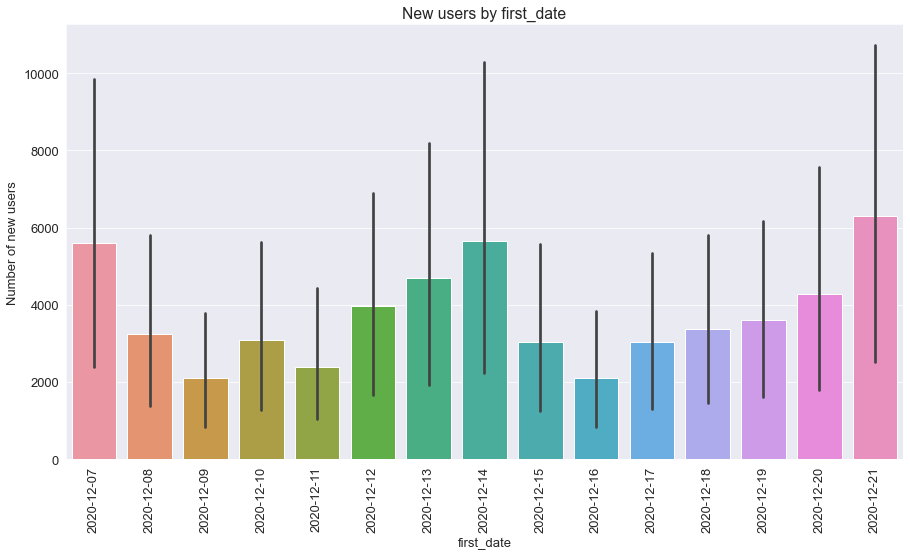

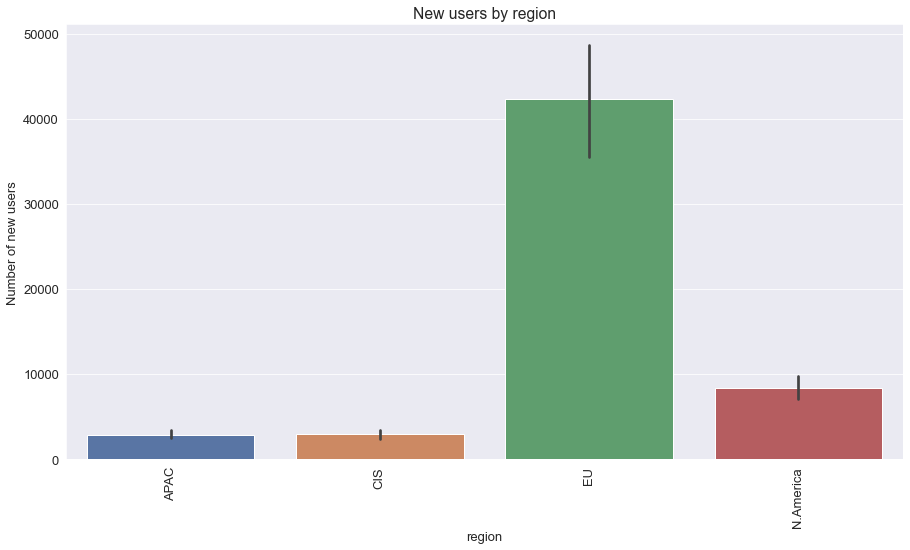

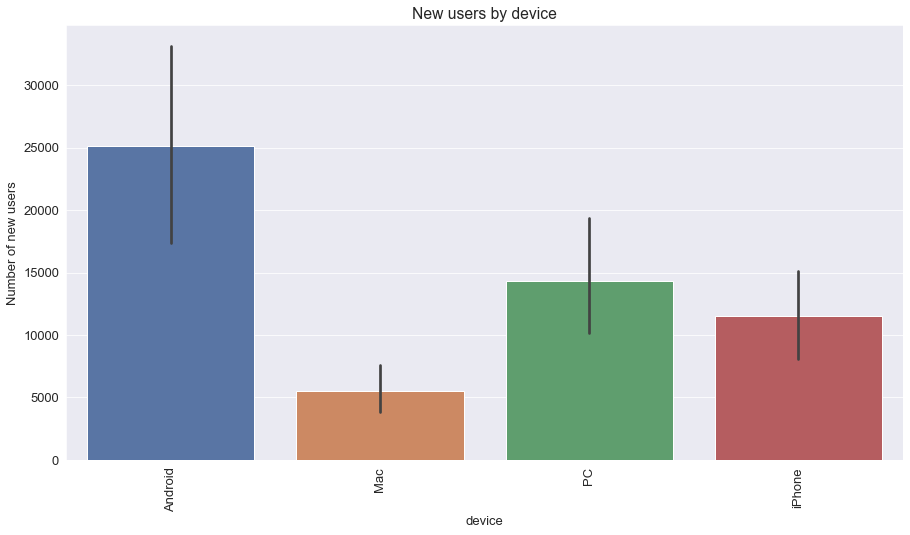

In [32]:
ab_new_users_agg['first_date'] = ab_new_users_agg['first_date'].dt.round('D').astype(str)
for col in ('first_date', 'region', 'device'):
    plt.figure(figsize=(15,8))
    sns.set_palette('deep')
    sns.set_style('darkgrid')
    ax = sns.barplot(
        x=col,
        y='user_id',
        data=ab_new_users_agg,
        estimator=sum)
    ax.set_title('New users by {}'.format(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Number of new users')
    ax.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)
    plt.show()

Peaks of registrations of new users are observed on Mondays, the least number of users is registered on Wednesdays. The vast majority of new users are in the EU region. Most of the users register from Android devices.

Since A/B test analyzes the behavior of users in the EU region, let's see if the behavior of users in this region differs from the rest in terms of registrations.

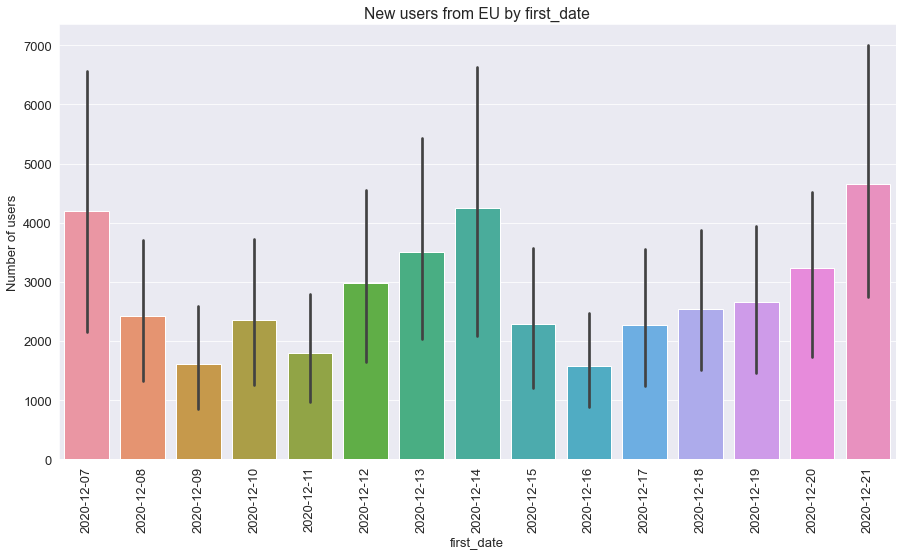

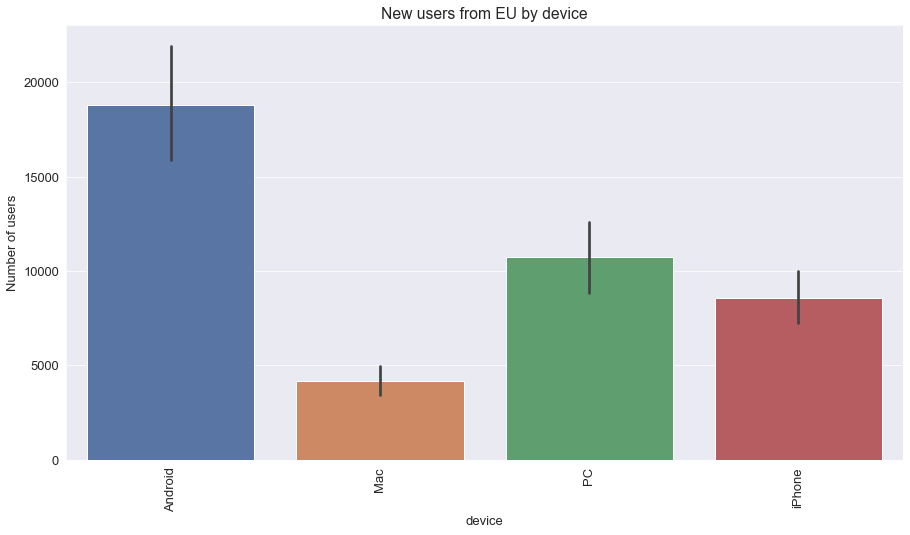

In [34]:
for col in ('first_date', 'device'):
    plt.figure(figsize=(15,8))
    sns.set_palette('deep')
    sns.set_style('darkgrid')
    ax = sns.barplot(
        x=col,
        y='user_id',
        data=ab_new_users_agg[ab_new_users_agg['region'] == 'EU'],
        estimator=sum)
    ax.set_title('New users from EU by {}'.format(col))
    ax.set_xlabel(col)
    ax.set_ylabel('Number of users')
    ax.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)
    plt.show()

The behavior of new users in EU differs little from the rest in terms of registrations .

Let's examine the data in the `ab_events` dataframe. Let's analyze the actions of new users and look at the dynamics of activity by event types. First, let's take a look at the `details` field.

In [35]:
for event_name in ab_events['event_name'].unique():
    print(event_name)
    print(ab_events[ab_events['event_name'] == event_name]['details'].unique())

purchase
[ 99.99   9.99   4.99 499.99]
product_cart
[nan]
product_page
[nan]
login
[nan]


The `details` field is only filled for events of the `purchase` type. Let's aggregate the data in the `ab_events` table by date and type of event, calculate the number of users and total revenue.

In [39]:
ab_events['event_date'] = ab_events['event_dt'].dt.round('D')
ab_events_agg = pd.DataFrame(
    ab_events
    .pivot_table(
        index=['event_date', 'event_name'],
        values=['user_id', 'details'],
        aggfunc={'user_id':'count',
                'details':'sum'})
    .to_records())
ab_events_agg.head(2)

event_date    event_name  details  user_id
0 2020-12-07         login     0.00     2490
1 2020-12-07  product_cart     0.00      799

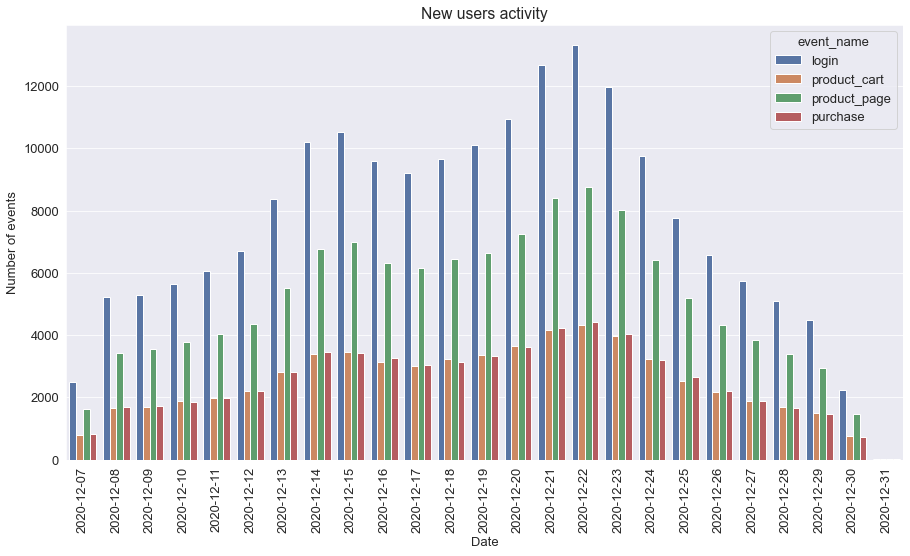

In [40]:
ab_events_agg['event_date'] = ab_events_agg['event_date'].dt.round('D').astype(str)
plt.figure(figsize=(15,8))
sns.set_palette('deep')
sns.set_style('darkgrid')
ax = sns.barplot(
    x='event_date',
    y='user_id',
    data=ab_events_agg,
    hue='event_name',
    estimator=sum)
ax.set_title('New users activity')
ax.set_xlabel('Date')
ax.set_ylabel('Number of events')
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

The peak of all types of activity of new users falls on Monday-Tuesday, the activity drops sharply by the new year.

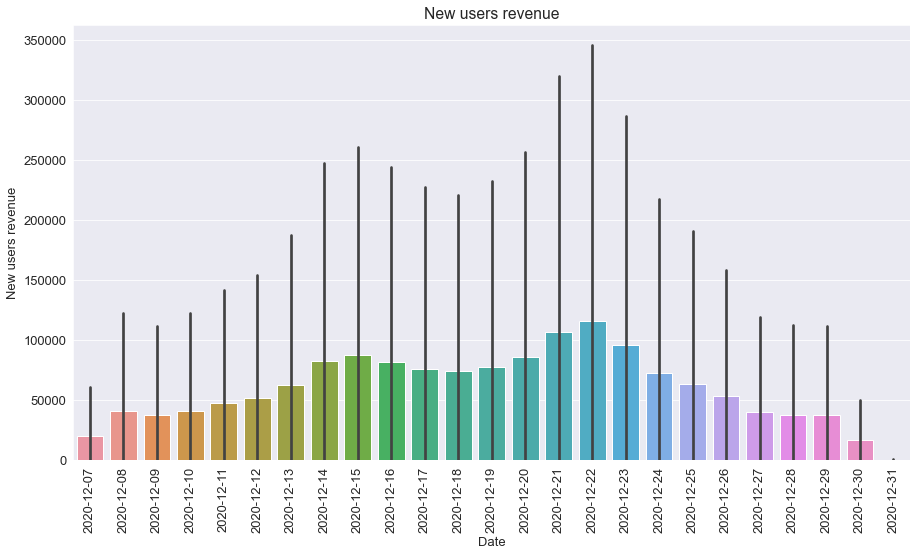

In [42]:
plt.figure(figsize=(15,8))
sns.set_palette('deep')
sns.set_style('darkgrid')
ax = sns.barplot(
    x='event_date',
    y='details',
    data=ab_events_agg,
    estimator=sum)
ax.set_title('New users revenue')
ax.set_xlabel('Date')
ax.set_ylabel('New users revenue')
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()

The largest amount of revenue from new users also falls on Monday-Tuesday, declining towards the new year. 

Let's study how the conversion in the funnel changes at different stages. Let's count the number of unique users who completed each type of action and plot a simple product funnel.

In [43]:
funnel_data = (
    ab_events
    .groupby(by='event_name', as_index=False)['user_id']
    .agg({'user_id': 'nunique'})
    .sort_values(by='user_id', ascending=False, ignore_index=True))
display(funnel_data)

event_name  user_id
0         login    58697
1  product_page    38929
2      purchase    19569
3  product_cart    19284

It turned out that there are more users who bought the product than users who viewed the shopping cart. This may be due to the fact that viewing the shopping cart is optional, the user can make a purchase by skipping this action. We will not take this step into account when building the funnel.

In [44]:
funnel_data = funnel_data[funnel_data['event_name'] != 'product_cart']
fig = go.Figure(go.Funnel(
    y = funnel_data['event_name'],
    x = funnel_data['user_id']
    ))
fig.update_layout(
    title='Simple product funnel')
fig.show()

Of the 58.7 thousand unique users who logged into the application, 38.9 thousand users viewed the product card (66.3% conversion from the previous step). Of those who viewed the product card, 50.3% made the purchase.

Let's examine the data in the `ab_participants` dataframe. Let's analyze the test participants dataframe. Only users from the EU region who registered on December 7-21 should be among the participants of the test. The expected effect of the test: within 14 days from the moment of registration, users will show an improvement in a number of metrics. Thus, it is possible to analyze only the actions of users, from the moment of registration of which until the moment of the last recorded event (December 30), 14 days or more have passed. These are users who had registered before December 17. Let's also check if there are any intersections with a competing test, as they can distort the results.

In [45]:
print('The dataframe contains the data of participants of the following tests:', ab_participants['ab_test'].unique())
print('Number of test participants of recommender_system_test:', 
      len(ab_participants[ab_participants['ab_test'] == 'recommender_system_test']))

The dataframe contains the data of participants of the following tests: ['recommender_system_test' 'interface_eu_test']
Number of test participants of recommender_system_test: 6701


In [54]:
participants = ab_participants[ab_participants['ab_test'] == 'recommender_system_test'].copy()
interface_eu_test_participants = ab_participants[ab_participants['ab_test'] == 'interface_eu_test'].copy()

In [55]:
print('Number of recommender_system_test participants who also participate in the competing test: {}'.format(
participants['user_id'].isin(interface_eu_test_participants['user_id']).sum()))

Number of recommender_system_test participants who also participate in the competing test: 1602


In [57]:
print('Number of recommender_system_test participants registered outside the EU region: {}'.format(
    participants['user_id'].isin(ab_new_users[ab_new_users['region'] != 'EU']['user_id']).sum()))

Number of recommender_system_test participants registered outside the EU region: 350


The number of test participants in the dataset exceeds the expected number of participants (6000). Intersections with a competing test is comprised by 1602 participants. There are participants outside the EU region. Let's leave in the dataframe only participants that meet the conditions of the A / B test.

In [58]:
participants = participants[
    (participants['user_id'].isin(
        ab_new_users[ab_new_users['region'] == 'EU']['user_id']))&
    (~participants['user_id'].isin(
        interface_eu_test_participants['user_id']))]
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4749 entries, 0 to 6350
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4749 non-null   object
 1   group    4749 non-null   object
 2   ab_test  4749 non-null   object
dtypes: object(3)
memory usage: 148.4+ KB


There were 4749 participants who met the conditions of the test. Let's look at the distribution of participants in test groups and the correctness of their formation.

In [59]:
participants.groupby(by='group', as_index=False)['user_id'].count()

group  user_id
0     A     2713
1     B     2036

In [60]:
print('The number of recommender_system_test participants who are in two groups at the same time: {}'.format(
participants[participants['group'] == 'A']['user_id'].isin(
    participants[participants['group'] == 'B']['user_id']).sum()))

The number of recommender_system_test participants who are in two groups at the same time: 0


The control group (A) included 2,713 participants in the A/B test. There are 2036 members in the new payment funnel group. None of the users fell into both groups.

Let's see if the number of events per user is equally distributed in the samples.

In [61]:
participants = participants.merge(
    ab_new_users[['user_id', 'first_date']],
    how='left',
    on='user_id')
participants.head(2)

user_id group                  ab_test first_date
0  D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07
1  A7A3664BD6242119     A  recommender_system_test 2020-12-20

In [62]:
participants_data = ab_events.merge(
    participants,
    how='inner',
    on='user_id')
participants_data.info()
participants_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17526 entries, 0 to 17525
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     17526 non-null  object        
 1   event_dt    17526 non-null  datetime64[ns]
 2   event_name  17526 non-null  object        
 3   details     2348 non-null   float64       
 4   event_date  17526 non-null  datetime64[ns]
 5   group       17526 non-null  object        
 6   ab_test     17526 non-null  object        
 7   first_date  17526 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(4)
memory usage: 1.2+ MB


user_id            event_dt event_name  details event_date group  \
0  831887FE7F2D6CBA 2020-12-07 06:50:29   purchase     4.99 2020-12-07     A   
1  831887FE7F2D6CBA 2020-12-09 02:19:17   purchase    99.99 2020-12-09     A   

                   ab_test first_date  
0  recommender_system_test 2020-12-07  
1  recommender_system_test 2020-12-07

In [63]:
events_per_user = pd.DataFrame(
    participants_data
    .pivot_table(
        index=['user_id','group', 'event_name'],
        values='event_dt',
        aggfunc='count')
    .to_records())
events_per_user.head(2)

user_id group    event_name  event_dt
0  0010A1C096941592     A         login         4
1  0010A1C096941592     A  product_page         4

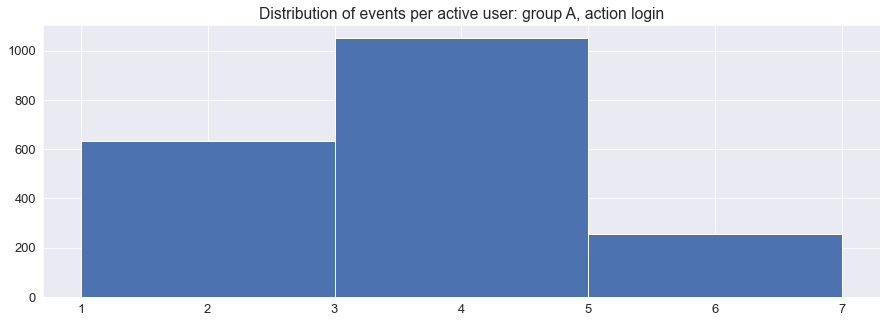

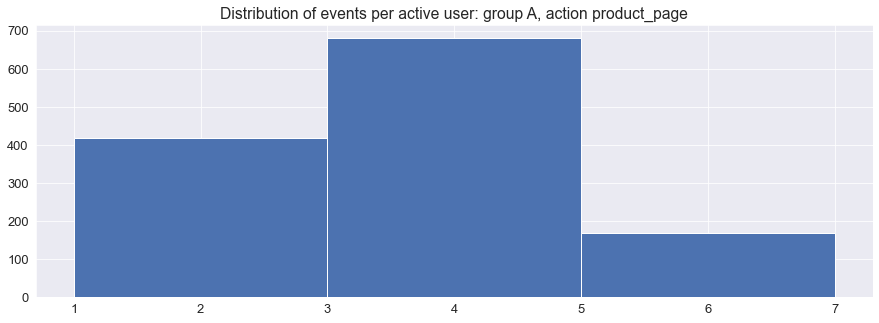

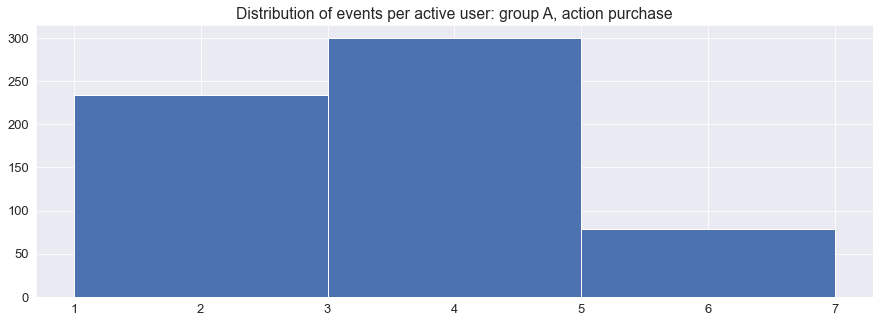

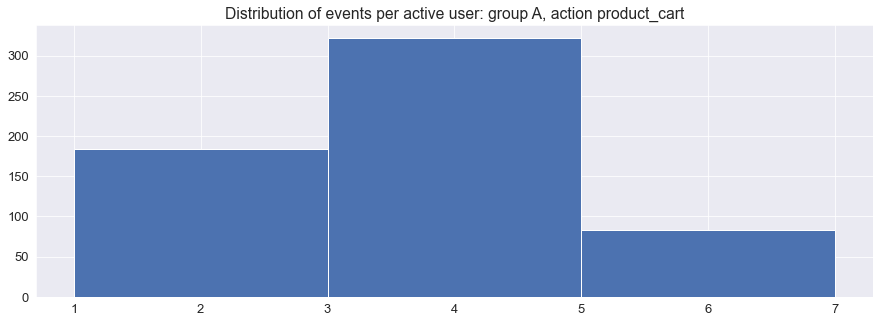

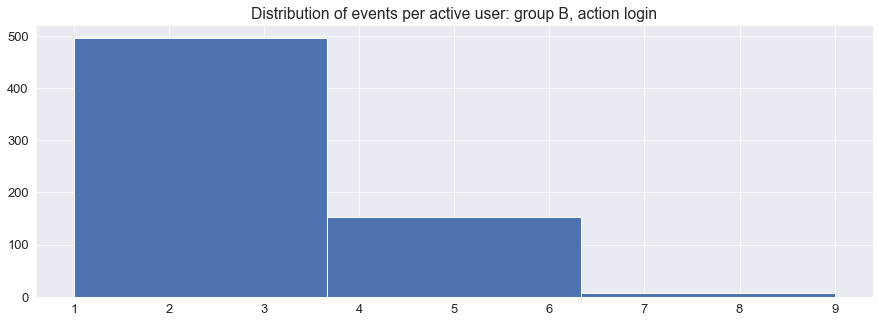

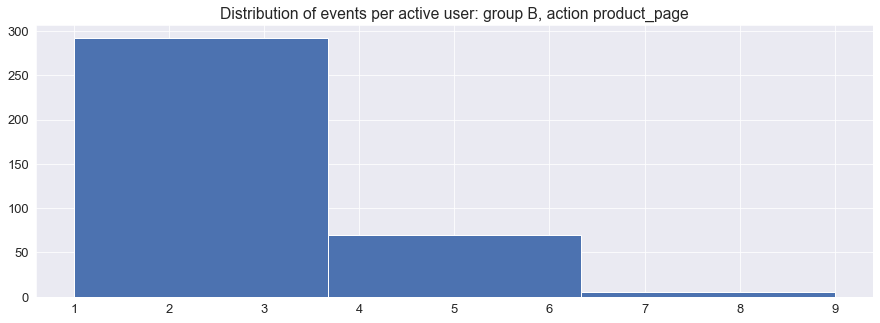

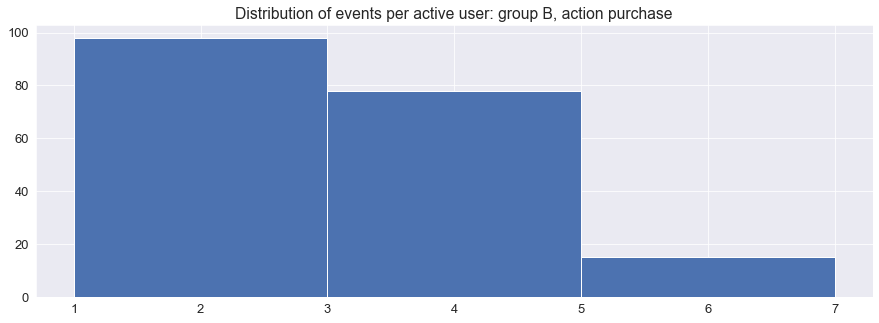

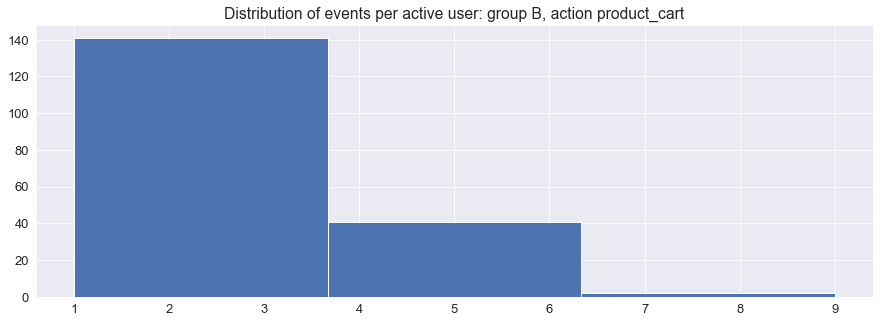

In [65]:
for group in events_per_user['group'].unique():
    for event in events_per_user['event_name'].unique():
        f, ax = plt.subplots(1, figsize=(15, 5))
        events_per_user[(events_per_user['group'] == group)&
                       (events_per_user['event_name'] == event)].hist(bins=3, ax=ax)
        plt.title('Distribution of events per active user: group {0}, action {1}'.format(group, event))

In group A, active users often make 3-5 actions of each type, and in group B an active user makes 1-3 actions.

## Conclusion on Exploratory data analysis and assessment of the test correctness
- A non-optimal time was chosen for the A/B test, as it coincides with marketing activities in the EU region and the New Year holidays.
- The volume of revenue and the activity of new users decreases by the new year (for all types of events).
- Of the 58.7 thousand unique users who logged into the application, 38.9 thousand users viewed the product card (66.3% conversion from the previous step). Of those who viewed the product card, 50.3% made the purchase.
- Intersections of participants with a competing test have been found. However, there are also participants outside the EU region, which contradicts the description of the test. They were excluded from the analysis.
- In group A, active users often make 3-5 actions of each type, and in group B an active user makes 1-3 actions.

# Analysis of A/B-test results

Let's look at the dynamics of cumulative metrics. Let's plot cumulative conversion for three types of events: `product_page`, `product_cart`, `purchase`. To do this, let's create necessary dataframes.

In [66]:
data_aggregated = participants_data[['event_date','group']].drop_duplicates(ignore_index=True)
data_aggregated = data_aggregated.rename(columns={'event_date':'date'})
data_aggregated = data_aggregated.sort_values(by='date', ignore_index=True)
data_aggregated.head(2)

date group
0 2020-12-07     A
1 2020-12-07     B

In [67]:
users_by_date = pd.DataFrame(
    participants
    .pivot_table(
        index=['first_date', 'group'],
        values='user_id',
        aggfunc='count')
    .to_records())
users_by_date = users_by_date.rename(columns={'first_date':'date'})
users_by_date.head(2)

date group  user_id
0 2020-12-07     A      260
1 2020-12-07     B      185

In [68]:
data_aggregated['total_users'] = (
    data_aggregated
    .apply(
        lambda x: users_by_date[
            (users_by_date['date'] <= x['date'])&
            (users_by_date['group'] == x['group'])]['user_id'].sum(),
        axis=1))
data_aggregated.head(2)

date group  total_users
0 2020-12-07     A          260
1 2020-12-07     B          185

In [69]:
for event in participants_data['event_name'].unique():
    data_aggregated[event] = (
        data_aggregated
        .apply(
            lambda x: participants_data[
                (participants_data['event_date'] <= x['date'])&
                (participants_data['group'] == x['group'])&
                (participants_data['event_name'] == event)]['user_id'].nunique(),
            axis=1))
data_aggregated.head(2)

date group  total_users  purchase  product_cart  login  product_page
0 2020-12-07     A          260        13            14     52            35
1 2020-12-07     B          185        21            18     60            37

In [70]:
events = ['product_page', 'product_cart', 'purchase']

In [71]:
for event in events:
    name=event+'_conversion'
    data_aggregated[name] = data_aggregated[event]/data_aggregated['total_users']
data_aggregated.head(2)

date group  total_users  purchase  product_cart  login  product_page  \
0 2020-12-07     A          260        13            14     52            35   
1 2020-12-07     B          185        21            18     60            37   

   product_page_conversion  product_cart_conversion  purchase_conversion  
0                     0.13                     0.05                 0.05  
1                     0.20                     0.10                 0.11

In [72]:
data_aggregated_A = data_aggregated[data_aggregated['group'] == 'A']
data_aggregated_B = data_aggregated[data_aggregated['group'] == 'B']

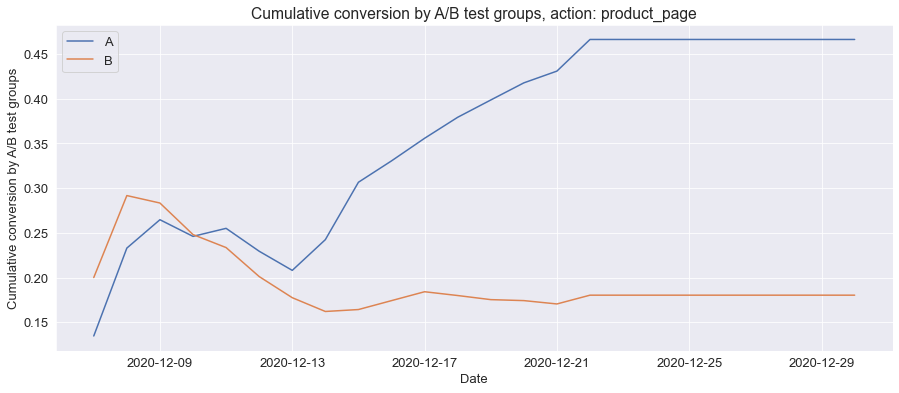

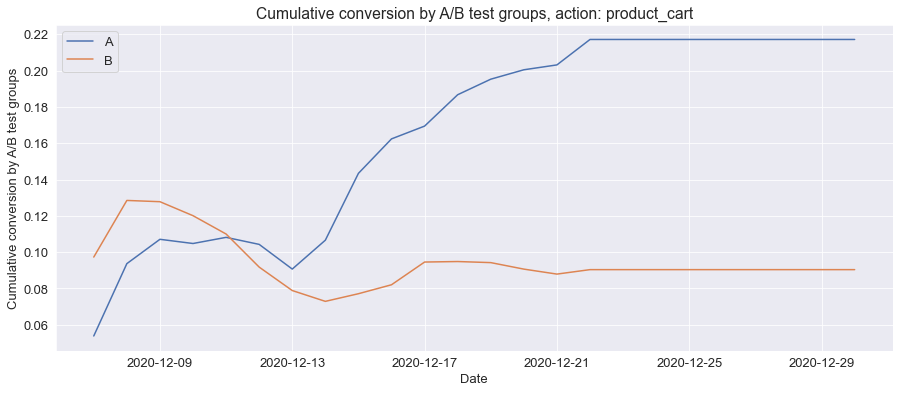

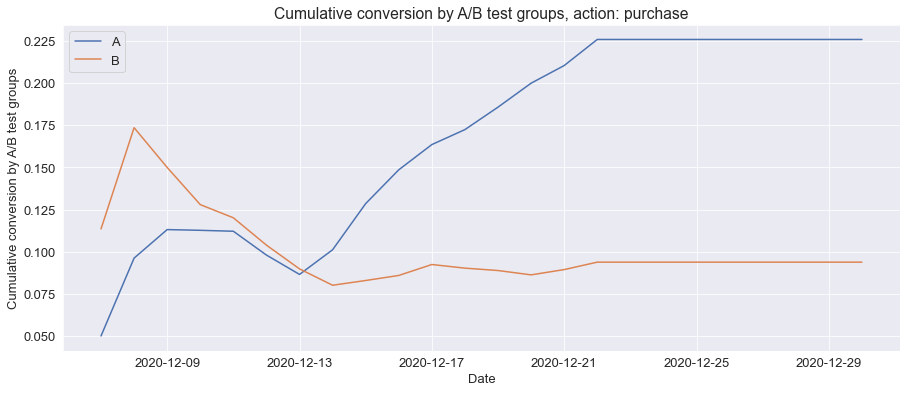

In [74]:
for envent in events:
    name=envent+'_conversion'
    plt.figure(figsize=(15,6))
    plt.plot(data_aggregated_A['date'], 
             data_aggregated_A[name], 
             label='A')
    plt.plot(data_aggregated_B['date'], 
             data_aggregated_B[name], 
             label='B')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Cumulative conversion by A/B test groups')
    plt.title('Cumulative conversion by A/B test groups, action: {}'.format(envent))
    plt.show()

In the first days of the test, the cumulative conversion for group B was higher than for group A for all types of events. However, a few days later, the conversion for group A exceeded the conversion for group B across all event types. 

Most likely, the expected effect (in 14 days from the moment of registration, users will show an improvement in each metric by at least 10%) was not achieved. Let's check it out. We will consider only users registered no later than 14 days before the last event in the dataset, and only actions performed by users within 14 days from the date of registration.

In [75]:
participants_data_ready = participants_data[
    (participants_data['first_date'] < pd.to_datetime('2020-12-17'))&
    ((participants_data['event_dt'] - participants_data['first_date']) <= pd.to_timedelta('14 days'))]
participants_ready = participants[
    participants['first_date'] < pd.to_datetime('2020-12-17')]

Let's create a dataframe with the required values: count the number of users who have performed all types of actions in each of the groups and add the total number of users in each group.

In [76]:
test = (
    pd.DataFrame(
        participants_data_ready
        .pivot_table(
            index='event_name',
            columns='group',
            values='user_id',
            aggfunc={'user_id':'nunique'})
        .to_records())
    .sort_values(
        by='A',
        ascending=False)
    .append({'event_name': 'total_users',
            'A': len(participants_ready[participants_ready['group'] == 'A']),
            'B': len(participants_ready[participants_ready['group'] == 'B'])},
            ignore_index=True)
    .set_index('event_name'))
display(test)

A     B
event_name              
login          969   449
product_page   623   253
product_cart   300   125
purchase       286   124
total_users   1743  1292

Let's choose the significance level `ɑ` equal to 0.05. To reduce the probability of a false positive result in multiple testing of hypotheses, we apply the Bonferroni correction to adjust the level of significance to reduce the group probability of a Type 1 error.

We have 2 different groups (A, B). And for every comparison between groups, we run a few more checks for each stage of the funnel (view product cards, cart views, purchase). Accordingly, we get comparisons within the group and between groups: 2 * 3 = 6 events.

In [77]:
alpha = .05
bonferroni_alpha = alpha / 6
print(f'Significance level taking into account the Bonferroni correction: {bonferroni_alpha:.3f}')

Significance level taking into account the Bonferroni correction: 0.008


Let's define a function that will receive a dataframe, group names, action names, and significance level value as input, and test the hypothesis about the equality of the corresponding conversions between groups.

In [78]:
def test_hypothesis(df, group1, group2, alpha, events):
    for event in events:
        p1 = df[group1][event]/df[group1]['total_users']
        p2 = df[group2][event]/df[group2]['total_users']
        p_combined = (df[group1][event] + df[group2][event]) / (df[group1]['total_users']+ df[group2]['total_users'])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/df[group1]['total_users'] + 
                                                                         1/df[group2]['total_users']))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        if (p_value < alpha):
            print (f'Groups {group1}, {group2}; событие: {event}'
                    +'\n\n'+
                    f'Share of users who performed the action in group {group1}: {p1:.0%}'
                    +'\n'+
                    f'Share of users who performed the action in group {group2}: {p2:.0%}'
                    +'\n\n'+
                    'H0: shares of users, who performed the action, does not differ between groups'
                    +'\n'+
                    'H1: shares of users, who performed the action, differ between groups'
                    +'\n\n'+
                    f'p-value: {p_value:.3f}; the H0 hypothesis is rejected: there is a significant difference between the shares')
        else:
            print (f'Группы {group1}, {group2}; событие: {event}'
                    +'\n\n'+
                    f'Share of users who performed the action in group {group1}: {p1:.0%}'
                    +'\n'+
                    f'Share of users who performed the action in group {group2}: {p2:.0%}'
                    +'\n\n'+
                    'H0: shares of users, who performed the action, does not differ between groups'
                    +'\n'+
                    'H1: shares of users, who performed the action, differ between groups'
                    +'\n\n'+
                    f'p-value: {p_value:.3f}; the H0 hypothesis can not be rejected: there is no significant difference between the shares')
        print('\n\n\n')

Let's check if the statistical tests find a difference between samples A and B. Let's check if the difference between groups is statistically significant. To do this, let's apply the defined function for all types of events.

In [79]:
test_hypothesis(test, 'A', 'B', alpha, events)

Groups A, B; событие: product_page

Share of users who performed the action in group A: 36%
Share of users who performed the action in group B: 20%

H0: shares of users, who performed the action, does not differ between groups
H1: shares of users, who performed the action, differ between groups

p-value: 0.000; the H0 hypothesis is rejected: there is a significant difference between the shares




Groups A, B; событие: product_cart

Share of users who performed the action in group A: 17%
Share of users who performed the action in group B: 10%

H0: shares of users, who performed the action, does not differ between groups
H1: shares of users, who performed the action, differ between groups

p-value: 0.000; the H0 hypothesis is rejected: there is a significant difference between the shares




Groups A, B; событие: purchase

Share of users who performed the action in group A: 16%
Share of users who performed the action in group B: 10%

H0: shares of users, who performed the action, does n

The difference in conversions between groups turned out to be statistically significant, in the case of group A, conversions are higher for all types of events.

## Conclusion on Analysis of A/B-test results
- During the first days of the test, the cumulative conversion for group B was higher than for group A for all types of events. However, after a few days, the conversion for group A exceeded the conversion for group B for all types of events, the difference stabilized.
- The difference in conversions between groups, calculated for user actions within 14 days from the date of registration, turned out to be statistically significant: in the case of group A, conversions are higher for all types of events.

# Conclusion
- A non-optimal time was chosen for the A/B test, as it coincides with marketing activities in the EU region and the New Year holidays.
- Despite the fact that the test was planned to be carried out until January 4, it makes sense to stop it: group B is clearly worse than control group A on all selected indicators.
- It is recommended to restart the test, taking into account all the mistakes.